In [1]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Transfer Learning for Insect Classification in Agricultural Environments

**Goal**: Train a convolutional neural network to classify insects from natural agricultural environments using transfer learning.

This notebook adapts the PyTorch transfer learning tutorial for insect detection and classification.

## Dataset

- **12 insect classes**: Ants, Bees, Beetles, Caterpillars, Earthworms, Earwigs, Grasshoppers, Moths, Slugs, Snails, Wasps, Weevils
- **Training images**: 11,499
- **Validation images**: 1,095
- **Test images**: 546

## Transfer Learning Approaches

We'll explore two transfer learning strategies:

1. **Finetuning the ConvNet**: Initialize with a pretrained ResNet18 model and train all layers
2. **ConvNet as fixed feature extractor**: Freeze all layers except the final fully connected layer


## 1. Import Libraries and Setup


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode


## 2. Load and Prepare Data

We use data augmentation for training to improve model generalization:
- Random resized crop
- Random horizontal flip
- Random rotation
- Color jitter

For validation and testing, we only apply normalization.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datas'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train_organized'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'valid_organized'), data_transforms['val']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test_organized'), data_transforms['test'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Check for available accelerator (CUDA, MPS, etc.)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device")
print(f"\nDataset sizes:")
print(f"  Training: {dataset_sizes['train']}")
print(f"  Validation: {dataset_sizes['val']}")
print(f"  Test: {dataset_sizes['test']}")
print(f"\nNumber of classes: {len(class_names)}")
print(f"Classes: {class_names}")


Using cuda device

Dataset sizes:
  Training: 11499
  Validation: 1095
  Test: 546

Number of classes: 12
Classes: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


## 3. Visualize Sample Images


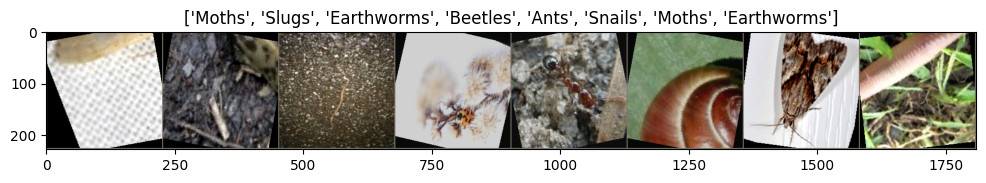

In [6]:
def imshow(inp, title=None):
    """Display image from Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])  # Show first 8 images

plt.figure(figsize=(12, 8))
imshow(out, title=[class_names[x] for x in classes[:8]])
plt.show()


## 4. Training Function

Generic function to train a model with:
- Learning rate scheduling
- Saving the best model
- Early stopping patience
- Training history tracking


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    """Train the model with early stopping."""
    since = time.time()
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        best_epoch = 0
        
        # Training history
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                # Save history
                history[f'{phase}_loss'].append(epoch_loss)
                history[f'{phase}_acc'].append(epoch_acc.item())
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Deep copy the model if it's the best so far
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    torch.save(model.state_dict(), best_model_params_path)
            
            print()
            
            # Early stopping
            if epoch - best_epoch >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')
        
        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    
    return model, history


## 5. Visualization Functions


In [5]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Val Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Val Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_model(model, num_images=12):
    """Display predictions for a few images."""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\\nActual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def visualize_model_predictions(model, img_path):
    """Make prediction on a single custom image."""
    was_training = model.training
    model.eval()
    
    img = Image.open(img_path)
    img_tensor = data_transforms['val'](img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)
        
        plt.figure(figsize=(8, 6))
        plt.axis('off')
        plt.title(f'Predicted: {class_names[preds[0]]} (Confidence: {conf[0]:.2%})')
        imshow(img_tensor.cpu().data[0])
        plt.show()
        
        model.train(mode=was_training)


### Model evaluations

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader, dataset_name='Test'):
    """Evaluate model and display metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'{dataset_name} Accuracy: {accuracy:.4f}\\n')
    
    # Classification report
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_preds, all_labels


## 7. Approach 1: Finetuning the Entire ConvNet

Load a pretrained ResNet18 model and replace the final fully connected layer to output 12 classes instead of 1000.
Train all parameters of the network.


In [16]:
# Load pretrained ResNet18
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Replace final fully connected layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # 12 classes

model_ft = model_ft.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print("Model architecture:")
print(f"Total parameters: {sum(p.numel() for p in model_ft.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_ft.parameters() if p.requires_grad):,}")


Model architecture:
Total parameters: 11,182,668
Trainable parameters: 11,182,668


### Train the Finetuned Model

This will take some time depending on your hardware. With GPU, it should take 10-20 minutes.


In [22]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                    num_epochs=25, patience=5)


Epoch 0/24
----------
train Loss: 1.1115 Acc: 0.6630
val Loss: 0.4586 Acc: 0.8612

Epoch 1/24
----------
train Loss: 0.6095 Acc: 0.8091
val Loss: 0.4025 Acc: 0.8721

Epoch 2/24
----------
train Loss: 0.5103 Acc: 0.8389
val Loss: 0.3689 Acc: 0.8776

Epoch 3/24
----------
train Loss: 0.4537 Acc: 0.8562
val Loss: 0.3754 Acc: 0.8822

Epoch 4/24
----------
train Loss: 0.4214 Acc: 0.8652
val Loss: 0.3765 Acc: 0.8831

Epoch 5/24
----------
train Loss: 0.3956 Acc: 0.8716
val Loss: 0.3914 Acc: 0.8731

Epoch 6/24
----------
train Loss: 0.3612 Acc: 0.8851
val Loss: 0.3727 Acc: 0.8804

Epoch 7/24
----------
train Loss: 0.3196 Acc: 0.8971
val Loss: 0.3720 Acc: 0.8776

Epoch 8/24
----------
train Loss: 0.2914 Acc: 0.9066
val Loss: 0.3606 Acc: 0.8831

Epoch 9/24
----------
train Loss: 0.2833 Acc: 0.9095
val Loss: 0.3576 Acc: 0.8877

Epoch 10/24
----------
train Loss: 0.2812 Acc: 0.9123
val Loss: 0.3693 Acc: 0.8831

Epoch 11/24
----------
train Loss: 0.2917 Acc: 0.9104
val Loss: 0.3668 Acc: 0.8858

Ep

### Visualize Training Results


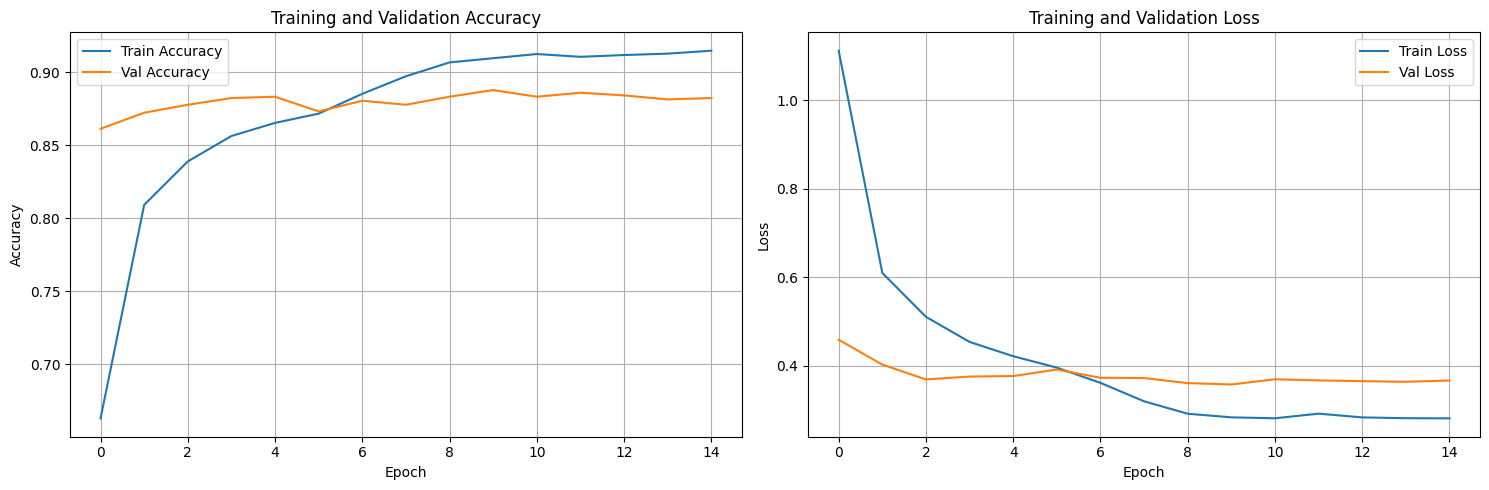

In [23]:
# Plot training history
plot_training_history(history_ft)


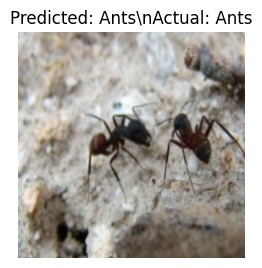

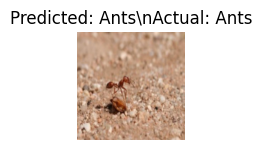

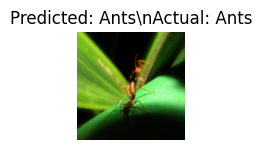

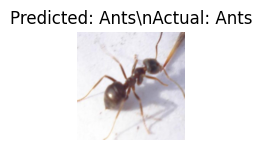

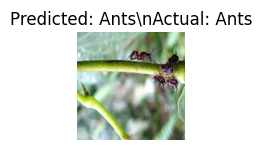

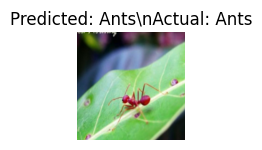

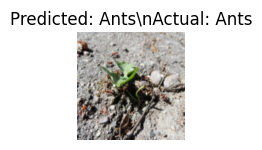

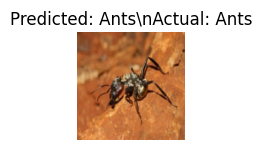

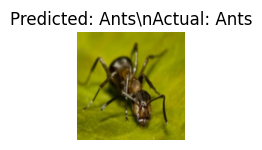

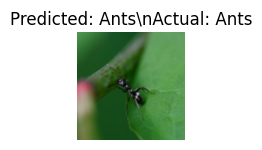

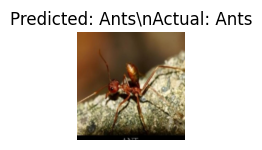

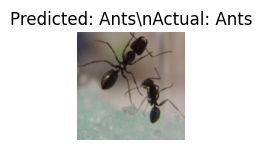

In [10]:
# Visualize predictions
visualize_model(model_ft, num_images=12)


### Evaluate on Test Set


Test Accuracy: 0.8810\n
Classification Report:
              precision    recall  f1-score   support

        Ants       0.93      0.98      0.95        54
        Bees       0.88      0.88      0.88        40
     Beetles       0.80      0.68      0.74        41
Caterpillars       0.78      0.78      0.78        46
  Earthworms       0.86      0.93      0.89        27
     Earwigs       0.92      0.75      0.82        59
Grasshoppers       0.74      0.92      0.82        38
       Moths       0.96      0.94      0.95        47
       Slugs       0.85      0.85      0.85        46
      Snails       0.96      0.98      0.97        44
       Wasps       0.92      0.96      0.94        46
     Weevils       0.93      0.95      0.94        58

    accuracy                           0.88       546
   macro avg       0.88      0.88      0.88       546
weighted avg       0.88      0.88      0.88       546



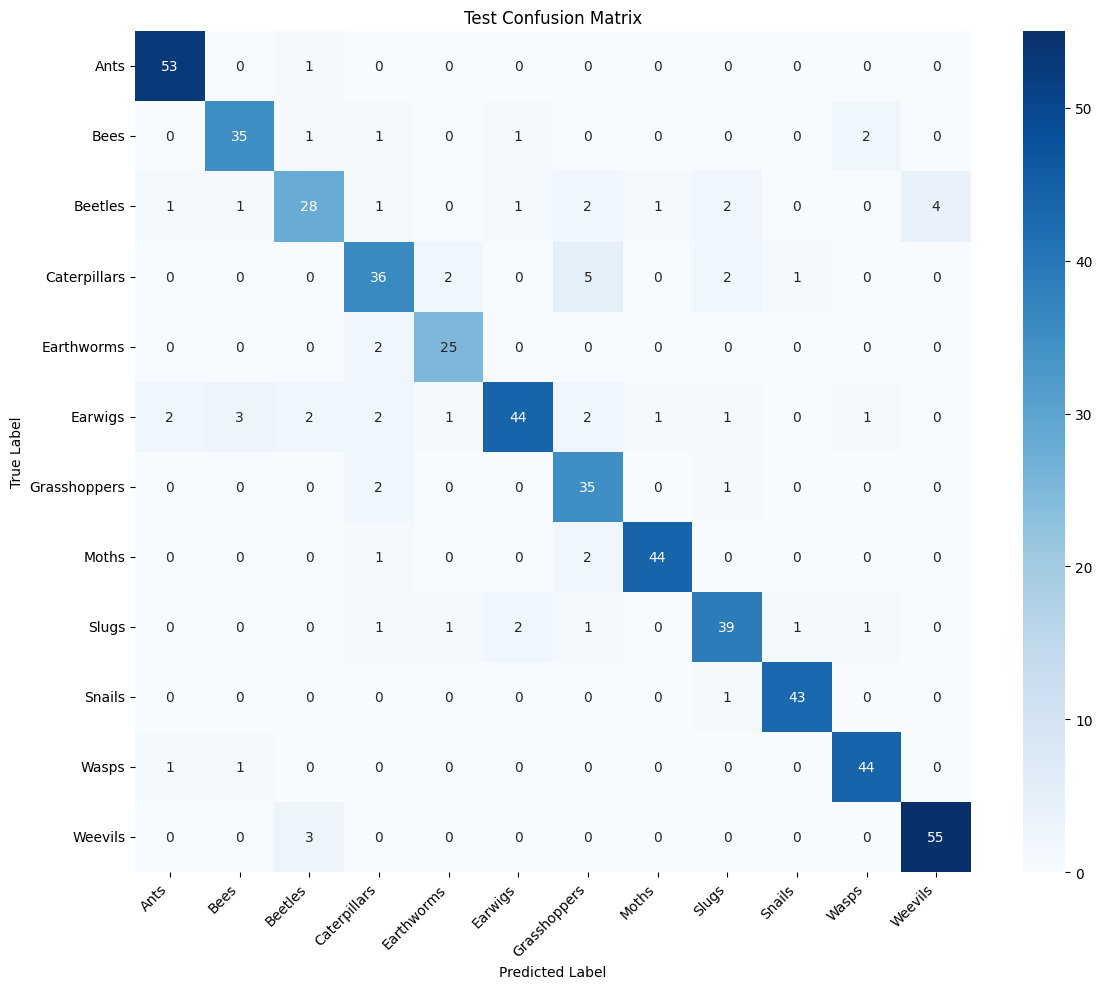

In [24]:
test_acc_ft, preds_ft, labels_ft = evaluate_model(model_ft, dataloaders['test'], 'Test')


### Save the Finetuned Model


In [14]:
# Save model
torch.save(model_ft.state_dict(), 'insect_classifier_finetuned.pth')
print("Model saved as 'insect_classifier_finetuned.pth'")


Model saved as 'insect_classifier_finetuned.pth'


## 9. Approach 3: DenseNet-121 with Optimized Training

DenseNet (Densely Connected Convolutional Networks) connects each layer to every other layer in a feed-forward fashion. 

**Key Advantages:**
- Alleviates vanishing gradient problem
- Strengthens feature propagation
- Encourages feature reuse
- Reduces number of parameters

**Best Training Practices for DenseNet:**
- Lower learning rate (0.0001) due to dense connections
- Adam optimizer for adaptive learning
- Higher dropout for regularization
- Cosine annealing for learning rate scheduling


In [9]:
# Load pretrained DenseNet-121
model_densenet = models.densenet121(weights='IMAGENET1K_V1')

# Replace final classifier layer
# DenseNet uses 'classifier' instead of 'fc'
num_ftrs_dense = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs_dense, len(class_names))

model_densenet = model_densenet.to(device)

# Loss function
criterion_dense = nn.CrossEntropyLoss()

# Adam optimizer works better for DenseNet (adaptive learning rates)
optimizer_densenet = optim.Adam(model_densenet.parameters(), lr=0.0001, weight_decay=1e-4)

# Cosine annealing learning rate scheduler
scheduler_densenet = lr_scheduler.CosineAnnealingLR(optimizer_densenet, T_max=25, eta_min=1e-6)

print("DenseNet-121 Model Architecture:")
print(f"Total parameters: {sum(p.numel() for p in model_densenet.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_densenet.parameters() if p.requires_grad):,}")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/ian/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100.0%


DenseNet-121 Model Architecture:
Total parameters: 6,966,156
Trainable parameters: 6,966,156


### Train DenseNet-121 Model


In [10]:
model_densenet, history_densenet = train_model(model_densenet, criterion_dense, optimizer_densenet, 
                                                 scheduler_densenet, num_epochs=25, patience=5)


Epoch 0/24
----------
train Loss: 0.8401 Acc: 0.7626
val Loss: 0.3629 Acc: 0.8904

Epoch 1/24
----------
train Loss: 0.4307 Acc: 0.8686
val Loss: 0.3299 Acc: 0.9005

Epoch 2/24
----------
train Loss: 0.3541 Acc: 0.8911
val Loss: 0.3282 Acc: 0.9032

Epoch 3/24
----------
train Loss: 0.3159 Acc: 0.9013
val Loss: 0.3471 Acc: 0.8968

Epoch 4/24
----------
train Loss: 0.2672 Acc: 0.9177
val Loss: 0.3687 Acc: 0.8932

Epoch 5/24
----------
train Loss: 0.2512 Acc: 0.9225
val Loss: 0.3327 Acc: 0.9014

Epoch 6/24
----------
train Loss: 0.2250 Acc: 0.9310
val Loss: 0.3545 Acc: 0.9023

Epoch 7/24
----------
train Loss: 0.2213 Acc: 0.9296
val Loss: 0.3429 Acc: 0.8995

Early stopping triggered after 8 epochs
Training complete in 7m 44s
Best val Acc: 0.9032


### Visualize DenseNet Training Results


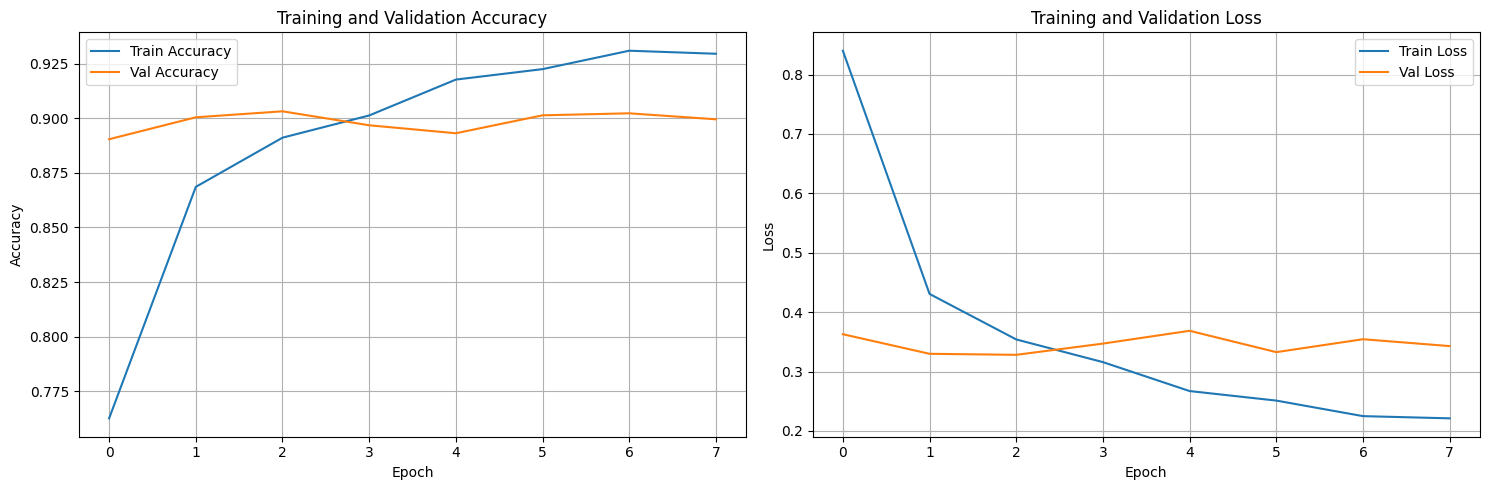

In [12]:
# Plot training history
plot_training_history(history_densenet)


In [ ]:
# Visualize predictions
visualize_model(model_densenet, num_images=12)


### Evaluate DenseNet on Test Set


Test Accuracy: 0.9011\n
Classification Report:
              precision    recall  f1-score   support

        Ants       0.93      0.98      0.95        54
        Bees       0.83      0.97      0.90        40
     Beetles       0.82      0.68      0.75        41
Caterpillars       0.79      0.89      0.84        46
  Earthworms       0.96      0.81      0.88        27
     Earwigs       0.94      0.80      0.86        59
Grasshoppers       0.84      0.97      0.90        38
       Moths       0.98      0.96      0.97        47
       Slugs       0.86      0.78      0.82        46
      Snails       0.94      1.00      0.97        44
       Wasps       0.96      0.96      0.96        46
     Weevils       0.97      0.97      0.97        58

    accuracy                           0.90       546
   macro avg       0.90      0.90      0.90       546
weighted avg       0.90      0.90      0.90       546



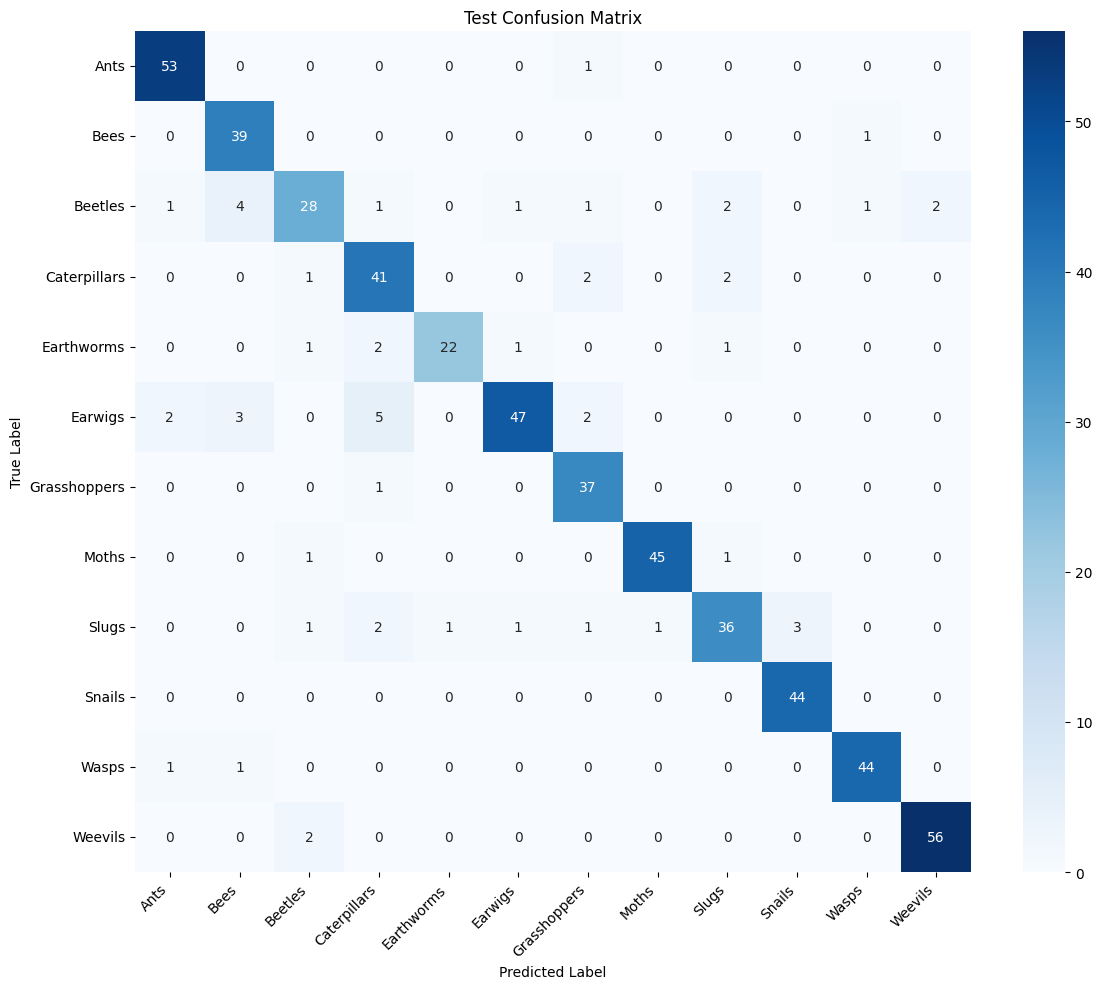

In [13]:
test_acc_densenet, preds_densenet, labels_densenet = evaluate_model(model_densenet, dataloaders['test'], 'Test')


### Save DenseNet Model


In [ ]:
# Save model
torch.save(model_densenet.state_dict(), 'insect_classifier_densenet121.pth')
print("Model saved as 'insect_classifier_densenet121.pth'")


## 10. Approach 4: EfficientNet-V2-S with Advanced Training

EfficientNet-V2 is a family of models that achieve state-of-the-art accuracy with better training efficiency.

**Key Features:**
- Compound scaling (depth, width, resolution)
- Fused-MBConv blocks for faster training
- Progressive learning with adaptive regularization
- Better parameter efficiency

**Best Training Practices for EfficientNet:**
- AdamW optimizer with weight decay
- Higher learning rate (0.001) with warm-up
- Progressive training (optional)
- MixUp/CutMix augmentation for robustness
- Exponential moving average (EMA) of weights


In [6]:
# Load pretrained EfficientNet-V2-S
model_efficientnet = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# Replace final classifier layer
# EfficientNet uses a classifier with multiple layers
num_ftrs_eff = model_efficientnet.classifier[1].in_features
model_efficientnet.classifier[1] = nn.Linear(num_ftrs_eff, len(class_names))

model_efficientnet = model_efficientnet.to(device)

# Loss function with label smoothing for better generalization
criterion_eff = nn.CrossEntropyLoss(label_smoothing=0.1)

# AdamW optimizer (Adam with decoupled weight decay)
optimizer_efficientnet = optim.AdamW(model_efficientnet.parameters(), 
                                      lr=0.0005, 
                                      weight_decay=0.01,
                                      betas=(0.9, 0.999))

# # Cosine annealing with warm restarts
# scheduler_efficientnet = lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer_efficientnet, 
#     T_0=10,  # Restart every 10 epochs
#     T_mult=1,
#     eta_min=1e-6
# )

# NEW (more stable):
scheduler_efficientnet = lr_scheduler.CosineAnnealingLR(
    optimizer_efficientnet, T_max=25, eta_min=1e-6
)

print("EfficientNet-V2-S Model Architecture:")
print(f"Total parameters: {sum(p.numel() for p in model_efficientnet.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_efficientnet.parameters() if p.requires_grad):,}")


EfficientNet-V2-S Model Architecture:
Total parameters: 20,192,860
Trainable parameters: 20,192,860


### Train EfficientNet-V2-S Model


In [7]:
model_efficientnet, history_efficientnet = train_model(model_efficientnet, criterion_eff, 
                                                        optimizer_efficientnet, scheduler_efficientnet, 
                                                        num_epochs=25, patience=5)


Epoch 0/24
----------
train Loss: 1.0953 Acc: 0.7814
val Loss: 0.8256 Acc: 0.8895

Epoch 1/24
----------
train Loss: 0.9233 Acc: 0.8432
val Loss: 0.8410 Acc: 0.8785

Epoch 2/24
----------
train Loss: 0.8457 Acc: 0.8749
val Loss: 0.8239 Acc: 0.8877

Epoch 3/24
----------
train Loss: 0.8079 Acc: 0.8903
val Loss: 0.8594 Acc: 0.8877

Epoch 4/24
----------
train Loss: 0.7979 Acc: 0.8924
val Loss: 0.8483 Acc: 0.8849

Epoch 5/24
----------
train Loss: 0.7708 Acc: 0.9087
val Loss: 0.8306 Acc: 0.8868

Early stopping triggered after 6 epochs
Training complete in 6m 26s
Best val Acc: 0.8895


### Visualize EfficientNet Training Results


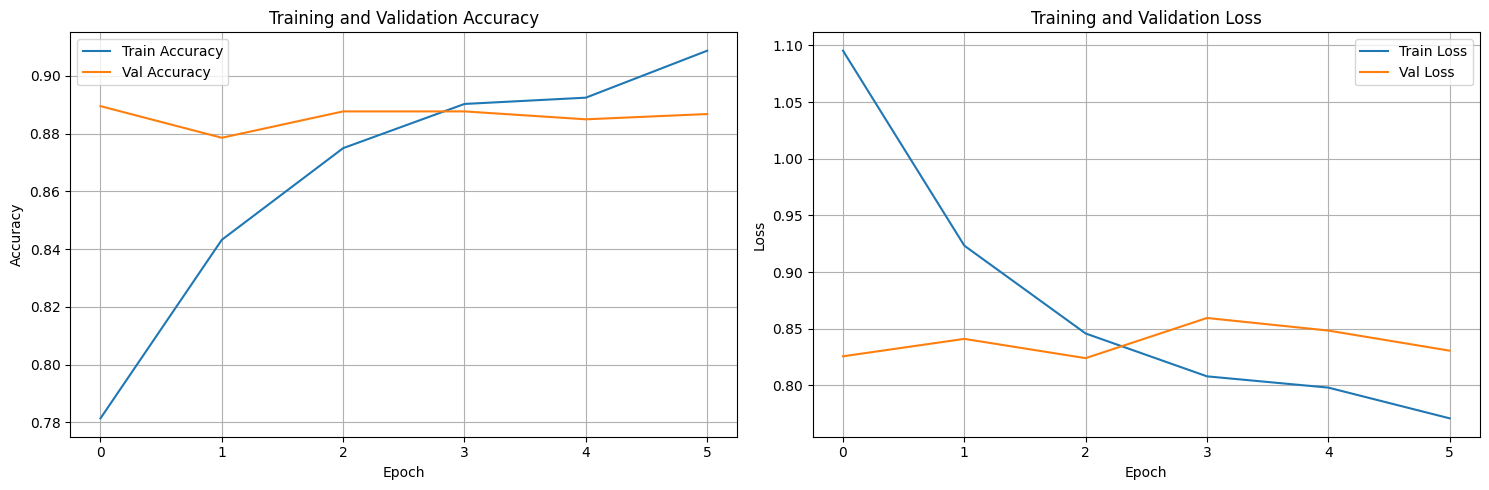

In [8]:
# Plot training history
plot_training_history(history_efficientnet)


In [ ]:
# Visualize predictions
visualize_model(model_efficientnet, num_images=12)


### Evaluate EfficientNet on Test Set


Test Accuracy: 0.8846\n
Classification Report:
              precision    recall  f1-score   support

        Ants       0.91      0.98      0.95        54
        Bees       0.88      0.95      0.92        40
     Beetles       0.71      0.59      0.64        41
Caterpillars       0.84      0.80      0.82        46
  Earthworms       0.88      0.85      0.87        27
     Earwigs       0.83      0.83      0.83        59
Grasshoppers       0.80      0.92      0.85        38
       Moths       1.00      0.91      0.96        47
       Slugs       0.84      0.83      0.84        46
      Snails       0.92      1.00      0.96        44
       Wasps       0.98      1.00      0.99        46
     Weevils       0.96      0.91      0.94        58

    accuracy                           0.88       546
   macro avg       0.88      0.88      0.88       546
weighted avg       0.88      0.88      0.88       546



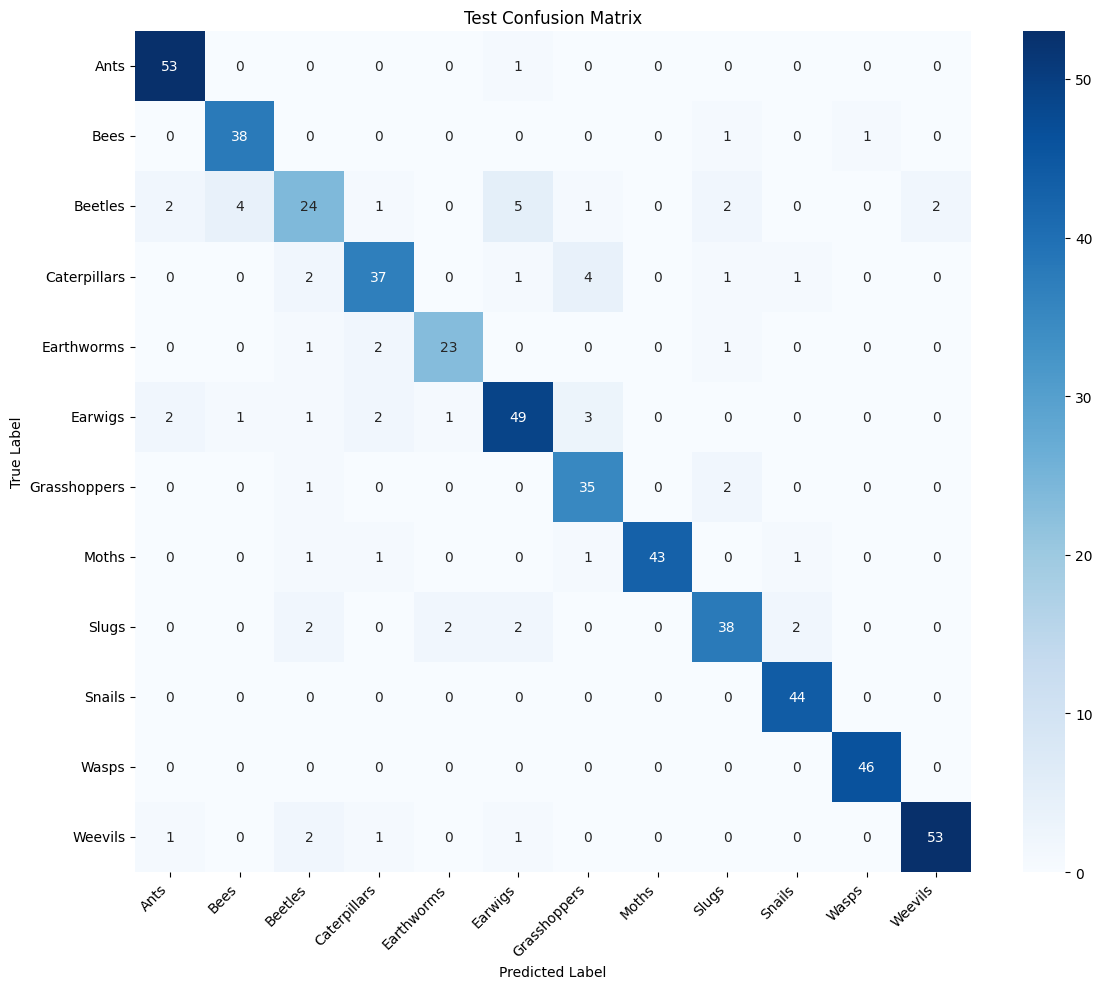

In [14]:
test_acc_efficientnet, preds_efficientnet, labels_efficientnet = evaluate_model(model_efficientnet, dataloaders['test'], 'Test')


### Save EfficientNet Model


In [ ]:
# Save model
torch.save(model_efficientnet.state_dict(), 'insect_classifier_efficientnet_v2_s.pth')
print("Model saved as 'insect_classifier_efficientnet_v2_s.pth'")


## 11. Compare All Models

Let's compare the performance of all four transfer learning approaches.


In [25]:
import pandas as pd

# Create comparison dataframe
comparison_data = {
    'Model': ['ResNet-18 (Finetuned)', 
              'DenseNet-121', 'EfficientNet-V2-S'],
    'Test Accuracy': [test_acc_ft, test_acc_densenet, test_acc_efficientnet],
    'Training Epochs': [len(history_ft['train_acc']),                    
                        len(history_densenet['train_acc']),
                        len(history_efficientnet['train_acc'])],
    'Best Val Accuracy': [max(history_ft['val_acc']),
                          max(history_densenet['val_acc']),
                          max(history_efficientnet['val_acc'])],
    'Optimizer': ['SGD', 'Adam', 'AdamW'],
    'LR Schedule': ['StepLR', 'CosineAnnealing', 'CosineWarmRestart']
}

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Test Accuracy', ascending=False)

print("="*80)
print("COMPARISON OF ALL TRANSFER LEARNING APPROACHES")
print("="*80)
print(df_comparison.to_string(index=False))
print("\n" + "="*80)

# Find best model
best_model_idx = df_comparison['Test Accuracy'].idxmax()
best_model_name = df_comparison.loc[best_model_idx, 'Model']
best_accuracy = df_comparison.loc[best_model_idx, 'Test Accuracy']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")


COMPARISON OF ALL TRANSFER LEARNING APPROACHES
                Model  Test Accuracy  Training Epochs  Best Val Accuracy Optimizer       LR Schedule
         DenseNet-121       0.901099                8           0.903196      Adam   CosineAnnealing
    EfficientNet-V2-S       0.886447               14           0.899543     AdamW CosineWarmRestart
ResNet-18 (Finetuned)       0.880952               15           0.887671       SGD            StepLR


🏆 Best Model: DenseNet-121
   Test Accuracy: 0.9011 (90.11%)


### Visualize All Models Training History


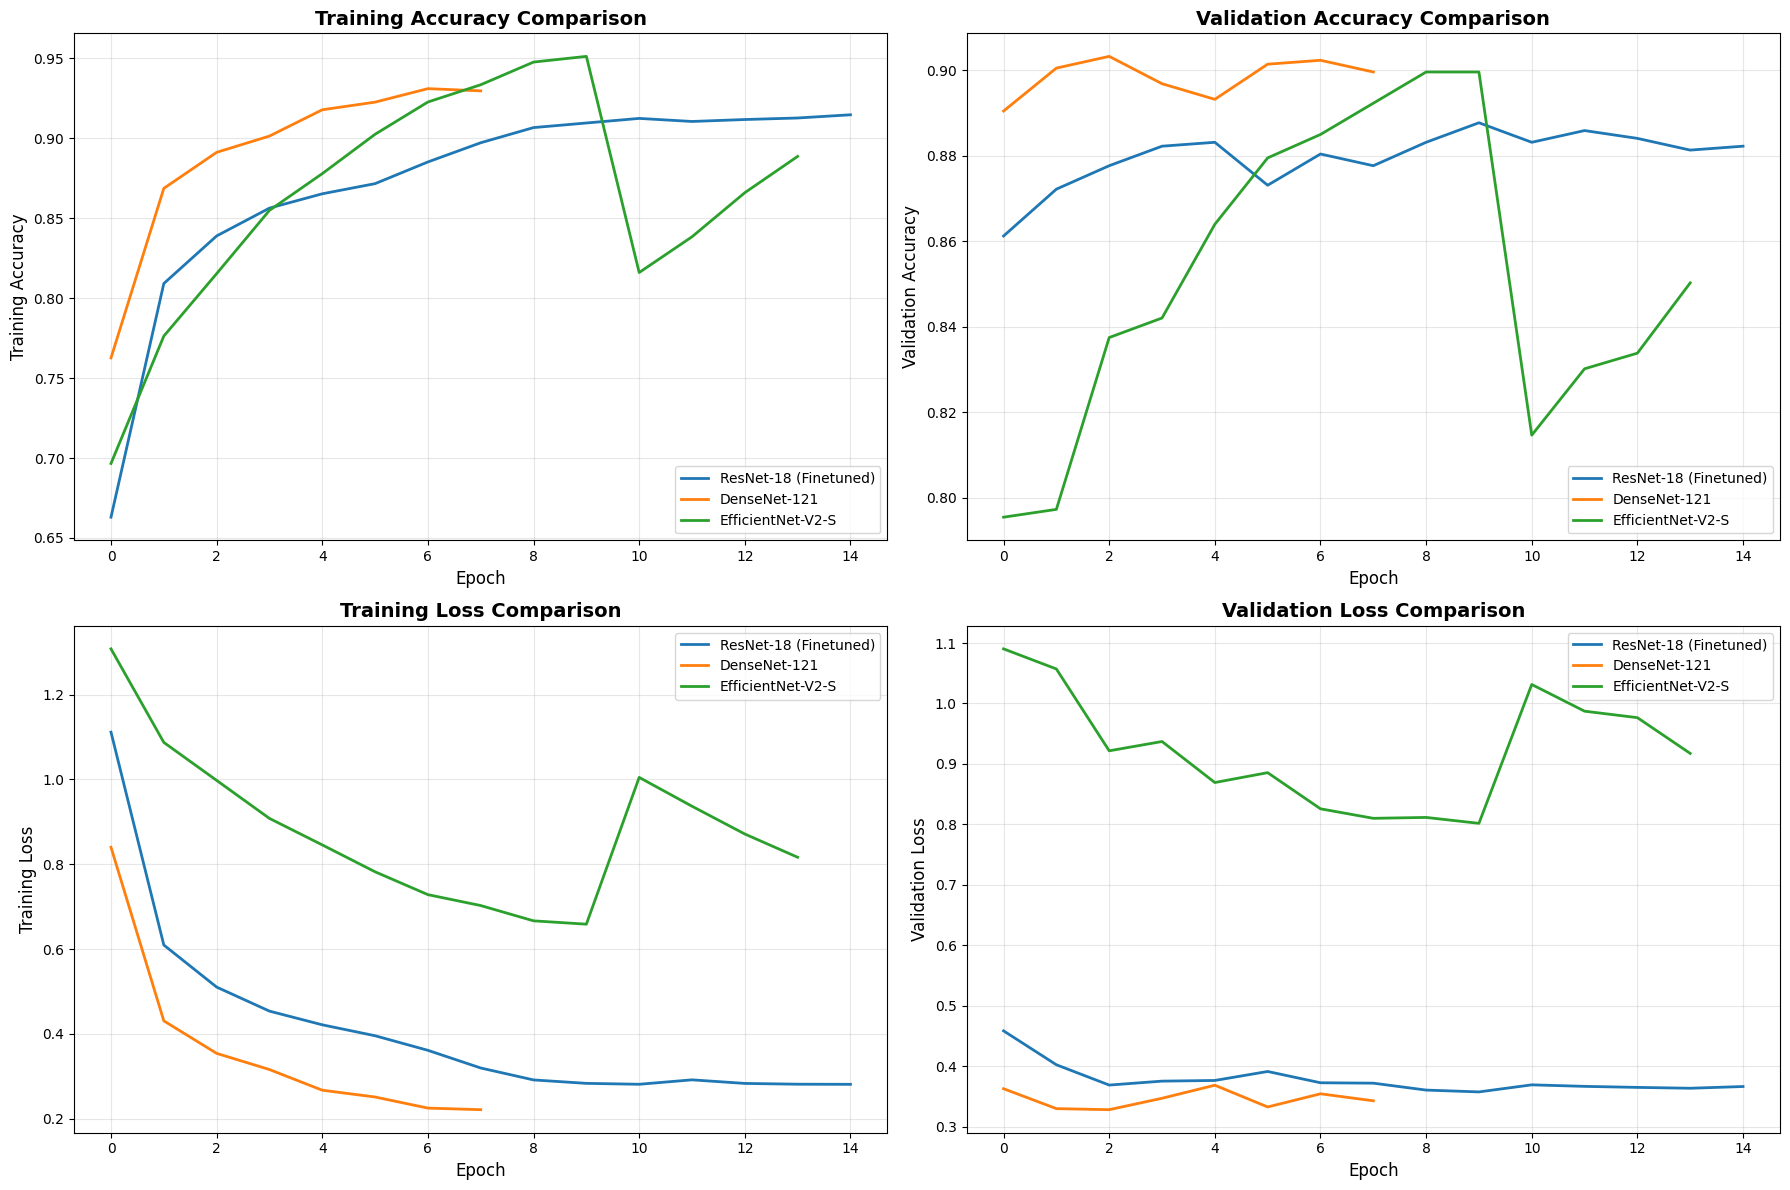

In [26]:
# Compare training curves of all models
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Training Accuracy Comparison
ax1 = axes[0, 0]
ax1.plot(history_ft['train_acc'], label='ResNet-18 (Finetuned)', linewidth=2)
# ax1.plot(history_conv['train_acc'], label='ResNet-18 (Feature Ext.)', linewidth=2)
ax1.plot(history_densenet['train_acc'], label='DenseNet-121', linewidth=2)
ax1.plot(history_efficientnet['train_acc'], label='EfficientNet-V2-S', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Accuracy', fontsize=12)
ax1.set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Comparison
ax2 = axes[0, 1]
ax2.plot(history_ft['val_acc'], label='ResNet-18 (Finetuned)', linewidth=2)
# ax2.plot(history_conv['val_acc'], label='ResNet-18 (Feature Ext.)', linewidth=2)
ax2.plot(history_densenet['val_acc'], label='DenseNet-121', linewidth=2)
ax2.plot(history_efficientnet['val_acc'], label='EfficientNet-V2-S', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# Plot 3: Training Loss Comparison
ax3 = axes[1, 0]
ax3.plot(history_ft['train_loss'], label='ResNet-18 (Finetuned)', linewidth=2)
# ax3.plot(history_conv['train_loss'], label='ResNet-18 (Feature Ext.)', linewidth=2)
ax3.plot(history_densenet['train_loss'], label='DenseNet-121', linewidth=2)
ax3.plot(history_efficientnet['train_loss'], label='EfficientNet-V2-S', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Training Loss', fontsize=12)
ax3.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Plot 4: Validation Loss Comparison
ax4 = axes[1, 1]
ax4.plot(history_ft['val_loss'], label='ResNet-18 (Finetuned)', linewidth=2)
# ax4.plot(history_conv['val_loss'], label='ResNet-18 (Feature Ext.)', linewidth=2)
ax4.plot(history_densenet['val_loss'], label='DenseNet-121', linewidth=2)
ax4.plot(history_efficientnet['val_loss'], label='EfficientNet-V2-S', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Validation Loss', fontsize=12)
ax4.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 12. Inference on Custom Images

Use any of the trained models to make predictions on any image from the test set or your own images.


In [ ]:
# Example: Make prediction on a test image
# Replace with your own image path
import random
import glob

# Get a random test image
test_images = glob.glob('datas/test_organized/*/*.jpg')
if test_images:
    sample_image = random.choice(test_images)
    print(f"Testing on: {sample_image}")
    visualize_model_predictions(model_ft, sample_image)
else:
    print("No test images found")


## Summary

In this notebook, we:
1. Organized the insect dataset for transfer learning
2. Applied data augmentation to improve generalization
3. Implemented two transfer learning approaches:
   - **Finetuning**: Training all layers of a pretrained ResNet18
   - **Feature Extraction**: Only training the final classification layer
4. Evaluated both models on a held-out test set
5. Visualized predictions and analyzed results

### Key Takeaways:
- Transfer learning allows us to leverage knowledge from ImageNet for insect classification
- Data augmentation helps prevent overfitting on agricultural images
- Both approaches can achieve good results, with finetuning typically providing better accuracy
- The feature extraction approach trains faster but may have slightly lower accuracy

### Next Steps:
- Try different pretrained models (ResNet50, EfficientNet, etc.)
- Experiment with different augmentation strategies
- Implement ensemble methods
- Deploy the model for real-time insect detection
